In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov

In [3]:
function generate_data(n,f_gp, σ_x, σ_y)
    obs = []
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])    
        # push!(obs, temp + σ_y*randn())
        push!(obs, temp)
    end
    return obs
end



generate_data (generic function with 1 method)

In [4]:
Random.seed!(1)

σ_c = 2pi/30 # true frequency
σ_y = 0.001 ## we assume low noise for now

N = 400; #data length
n = 400; #length of the axis of gp 

## GP information
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(Matern52Kernel(),θ)
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 1. #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
slicedim(dim) = (a) -> map(e -> e[dim], a);

In [5]:
#Generate data 
y_data = generate_data(N,f_train,σ_c,σ_y);

In [6]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,2000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/2000
                v_ = sum((samples .- m_).^2) /2000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

In [7]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


# function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
#     sample_left = rand(left,2000)
#     weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
#     weight = weights / sum(weights)
#     m = sum(weight .* log.(sample_left))
#     v = sum(weight .* (log.(sample_left) .- m).^2)
#     return LogNormal(m,v)
# end

function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,500)
    f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
    m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
    v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    if isnan(v)
        k = sample_left .* p_samples_evaluated .* f_samples_evaluated
        for i =1:length(k) 
            if isnan(k[i])
                sample_left[i] = 1e-2
            end
        end
        f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
        p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
        m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
        v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    end
    return LogNormal(m,v)
end


In [13]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    #mean_in and var_in come from m_A
    backward_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in = m_in, meta=meta)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    return ContinuousUnivariateLogPdf(backward_A)
end

In [8]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, P∞,A,Q,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f_prev = f_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.01))}
        c[i] ~ NormalMeanPrecision(0.0,1/(σ_c)^2) 
        y[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection()}
        # y[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
        f_prev = f[i]
    end
end

In [9]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ = [0.9, 1.]; # store [l, σ²]
Δt = [time_range[2] - time_range[1]]; # time difference
append!(Δt, time_range[2:end] - time_range[1:end-1]);

λ = sqrt(5)/θ[1];

L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [31]:
A[1] == A[2]

true

In [14]:
nits =2

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞,A,Q,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(), z = KeepLast(),),
    options = (limit_stack_depth=100,),
    showprogress = true
)

Inference results:
  Posteriors       | available for (f, z)


In [15]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

# mean_z = mean.(iresult.posteriors[:z])


400-element Vector{Float64}:
 0.9128941610703304
 0.9284339072594451
 0.9445593528628428
 0.9612841695157868
 0.9786216173878926
 0.9965844374141636
 1.0151847526067592
 1.0344339565277303
 1.0543425968476803
 1.074920260409524
 ⋮
 1.1519743273088145
 1.1554708294349796
 1.1590635899207038
 1.1627386120565533
 1.166482508232833
 1.1702825145664744
 1.1741264761374053
 1.1780028237521432
 1.1819005560151847

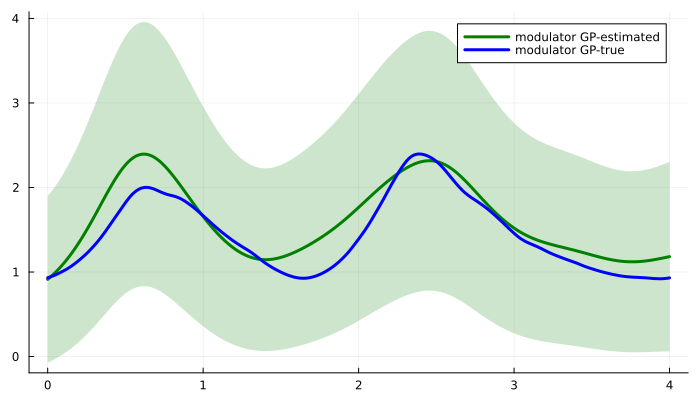

In [16]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size = (700, 400))
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
# plot!(time_range, y_data, color=:black,label = "modulated signal")

## Learn Hyperparameters
Assume $\sigma = 1$ and we only care about the length-scale l

In [33]:
# we input logλ
function compute_F(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ)^3 -3exp(logλ)^2 -3exp(logλ)]
    return F 
end

function compute_A(logλ)
    F = compute_F(logλ)
    A = exp(F * 0.010025062656641603)
    return A 
end

function compute_P∞(logλ)
    F = compute_F(logλ)
    A = compute_A(logλ)
    Qc = 16/3 * exp(logλ)^5
    Imat = diageye(3) ; 
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    return P∞
end

function compute_Q(logλ)
    P∞ = compute_P∞(logλ)
    A = compute_A(logλ)
    Q = P∞ - A*P∞*A'
    return Q 
end

compute_Q (generic function with 1 method)

In [34]:
time_range[2] - time_range[1]

0.010025062656641603

In [35]:
# θ = [0.9, 1.]; # store [l, σ²]
Δt = time_range[2] - time_range[1]; # time difference

l_init = 0.8;
logλ_init = log(sqrt(5)/l_init);

# L = [0., 0., 1.];
H = [1., 0., 0.];
# F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
# Qc = 16/3 * θ[2] * λ^5;

# Imat = diageye(3) ; 
# vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
# P∞ = reshape(vec_P,3,3);
# A = [exp(F * i) for i in Δt]; 
# Q = [P∞ - i*P∞*i' for i in A];

3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [44]:
@model function gp_PAD_hyperparams(n, l_λ_init,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    w = randomvar(n)
    B = randomvar(n)
    
    l_λ ~ NormalMeanVariance(l_λ_init, 20.)
    P∞ ~ compute_P∞(l_λ)
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    A ~ compute_A(l_λ)
    Qc ~ compute_Q(l_λ)
    f_prev = f_0
    for i=1:n 
        B[i] ~ (*)(A,f_prev) where {meta = TinyCorrection()}
        f[i] ~ MvNormalMeanCovariance(B[i], Qc)
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.01))}
        c[i] ~ NormalMeanPrecision(0.0,1/(σ_c)^2) 
        w[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection()}
        y[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
        f_prev = f[i]
    end
end

In [80]:
#specify CVI meta 
@meta function gp_PAD_meta()
    compute_P∞() -> Unscented(alpha = 1.1)
    compute_A() -> Unscented(alpha = 1.1)
    compute_Q() -> Unscented(alpha = 1.1)
end

#specify constraints 

@constraints function gp_PAD_constraints()
    q(f,B,Qc) = q(f)q(B)q(Qc)
    q(A,l_λ) = q(l_λ)q(A)
end;

In [81]:
@rule MvNormalMeanCovariance(:Σ, Marginalisation) (m_out::MvNormalMeanCovariance, q_μ::PointMass, ) = begin 
    return @call_rule MvNormalMeanCovariance(:Σ, Marginalisation) (q_out = m_out, q_μ = q_μ)
end

In [85]:
nits =1

iresult = inference(
    model = gp_PAD_hyperparams(length(y_data),logλ_init,H),
    iterations = nits, 
    data  = (y = y_data,),
    # initmarginals = (l_λ = NormalMeanVariance(logλ_init, 20.), f_0 = MvNormalMeanCovariance(zeros(3),diageye(3)),),
    initmessages = (l_λ = NormalMeanVariance(logλ_init, 20.),f_0 = MvNormalMeanCovariance(zeros(3),diageye(3)),),
    returnvars = (l_λ = KeepLast(),),
    options = (limit_stack_depth=100,),
    constraints = gp_PAD_constraints(),
    meta = gp_PAD_meta(),
    showprogress = true
)

point = -92.84123687760714


DimensionMismatch: DimensionMismatch: cannot broadcast array to have fewer non-singleton dimensions

## Use Real data 

In [17]:
using WAV, MAT

In [18]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [19]:
data = FilteredOutput[:,2];
NumberOfSamples = length(data);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
data = data / sqrt(var(data));

# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

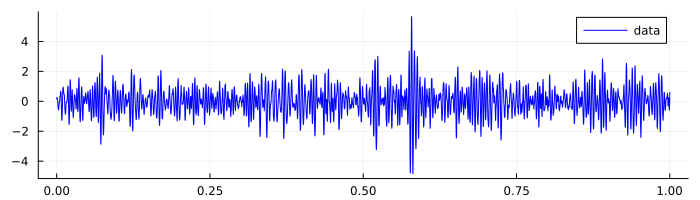

In [20]:
from = 1 
to = length(y_data)
skip = 1

plot(t_data,y_data,size = (700,200), color=:blue, label= "data")

In [21]:
@model function gp_AmplitudeDemodulation(n, P∞,A,Q,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f_prev = f_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.01))}
        c[i] ~ NormalMeanPrecision(0.0,1.) 
        y[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection()}
        # y[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
        f_prev = f[i]
    end
end

In [22]:
#### specify all hyperparameters
θ = [0.025, 1.]; # store [l, σ²]
Δt = [t_data[1]]; # time difference
append!(Δt, t_data[2:end] - t_data[1:end-1]);
# Δt = 0.0001 * ones(length(t_data))

λ = sqrt(5)/θ[1];
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [23]:
nits =2

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞,A,Q,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(),),
    options = (limit_stack_depth=100,),
    showprogress = true
)

Inference results:
  Posteriors       | available for (f)


In [24]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

In [218]:
# from = 1
# to = length(y_data)
# skip = 1
# plot(t_data[from:skip:to],mz[from:skip:to],ribbon=sqrt.(vz),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:red, size=(800,200))
# plot!(t_data[from:skip:to],y_data[from:skip:to], label="data",alpha=0.9,ms=3, color=:blue)

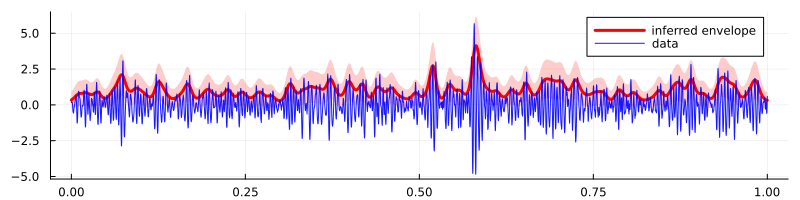

In [25]:
from = 1
to = length(y_data)
skip = 1
plot(t_data[from:skip:to],expmgp[from:skip:to],ribbon=sqrt.(expvgp),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:red, size=(800,200))
plot!(t_data[from:skip:to],y_data[from:skip:to], label="data",alpha=0.9,ms=3, color=:blue)